In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_score

from scipy import stats

from sklearn.linear_model import Ridge
from sklearn import tree


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the original predictions from the baseline model, which are to be post-processed in this notebook

In [3]:
test_and_val_data = pd.read_csv('/content/drive/My Drive/test_and_val_data_sep.csv')

In [4]:
print(test_and_val_data)

          prediction  label  group
0           0.006977    0.0    0.0
1           0.001521    0.0    0.0
2           0.001443    0.0    0.0
3           0.001510    0.0    0.0
4           0.001141    0.0    0.0
...              ...    ...    ...
81919995    0.322601    0.0    1.0
81919996    0.280586    1.0    1.0
81919997    0.254253    1.0    1.0
81919998    0.176560    1.0    1.0
81919999    0.225930    1.0    1.0

[81920000 rows x 3 columns]


In [5]:
masks = test_and_val_data['label'].values

In [13]:
def calc_FNR_FPR(y, y_pred):
    """
    Returns the FNR and FPR
    """
    fnr = 1 - y_pred[y == 1].mean()
    fpr = y_pred[y == 0].mean()
    
    return fnr, fpr

In [14]:
total_f1_base = f1_score(test_and_val_data['label'].values, np.round(test_and_val_data['prediction'].values))
print("Baseline F1 score: ", total_f1_base)

total_acc_base = accuracy_score(test_and_val_data['label'].values, np.round(test_and_val_data['prediction'].values))
print("Baseline Accuracy: ", total_acc_base)

total_jacc_base = jaccard_score(test_and_val_data['label'].values, np.round(test_and_val_data['prediction'].values), average = 'weighted')
print("Baseline Jaccard: ", total_jacc_base)

total_fnr_base, total_fpr_base = calc_FNR_FPR(test_and_val_data['label'].values, np.round(test_and_val_data['prediction'].values))
print("Baseline Overall FNR: ", total_fnr_base)
print("Baseline Overall FPR: ", total_fpr_base)

Baseline F1 score:  0.6858144113644564
Baseline Accuracy:  0.957889013671875
Baseline Jaccard:  0.9221332872259185
Baseline Overall FNR:  0.40857112428087794
Baseline Overall FPR:  0.011233423490598183


In [16]:
# Calculate Total Metrics - before post-processing
prot_pred = test_and_val_data.loc[test_and_val_data['group'] == 1]['prediction'].values
prot_actual = test_and_val_data.loc[test_and_val_data['group'] == 1]['label'].values

other_pred = test_and_val_data.loc[test_and_val_data['group'] == 0]['prediction'].values
other_actual = test_and_val_data.loc[test_and_val_data['group'] == 0]['label'].values

jacc_prot = jaccard_score(prot_actual, np.round(prot_pred), average = 'weighted')
jacc_other = jaccard_score(other_actual, np.round(other_pred), average = 'weighted')
print("Jaccard Score Protected Group: ", jacc_prot)
print("Jaccard Score Other Group: ", jacc_other)

fnr_prot, fpr_prot = calc_FNR_FPR(prot_actual, np.round(prot_pred))
fnr_other, fpr_other = calc_FNR_FPR(other_actual, np.round(other_pred))
print("FNR Protected Group: ", fnr_prot)
print("FNR Other Group: ", fnr_other)
print("FPR Protected Group: ", fpr_prot)
print("FPR Other Group: ", fpr_other)

Jaccard Score Protected Group:  0.7674370639152407
Jaccard Score Other Group:  0.9513534384683121
FNR Protected Group:  0.4244913708847692
FNR Other Group:  0.39546833132543746
FPR Protected Group:  0.0442524863481209
FPR Other Group:  0.006458797566951635


In [17]:
del prot_pred, prot_actual, other_pred, other_actual

In [18]:
# This section of code is taken from Pleiss et al. 2015 and adapted to provide additional metrics 
# (https://github.com/gpleiss/equalized_odds_and_calibration/blob/master/eq_odds.py)

import cvxpy as cvx
import numpy as np
from collections import namedtuple


class Model(namedtuple('Model', 'pred label')):
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def f1(self):
        return f1_score(self.pred.round(), self.label)
    
    def auc(self):
        return roc_auc_score(self.label, self.pred.round())

    def jaccard(self):
        return jaccard_score(self.label, self.pred.round(), average='weighted')

    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)

        self_fair_pred = self.pred.copy()
        self_pp_indices, = np.nonzero(self.pred.round())
        self_pn_indices, = np.nonzero(1 - self.pred.round())
        np.random.shuffle(self_pp_indices)
        np.random.shuffle(self_pn_indices)

        n2p_indices = self_pn_indices[:int(len(self_pn_indices) * sn2p)]
        self_fair_pred[n2p_indices] = 1 - self_fair_pred[n2p_indices]
        p2n_indices = self_pp_indices[:int(len(self_pp_indices) * (1 - sp2p))]
        self_fair_pred[p2n_indices] = 1 - self_fair_pred[p2n_indices]

        othr_fair_pred = othr.pred.copy()
        othr_pp_indices, = np.nonzero(othr.pred.round())
        othr_pn_indices, = np.nonzero(1 - othr.pred.round())
        np.random.shuffle(othr_pp_indices)
        np.random.shuffle(othr_pn_indices)

        n2p_indices = othr_pn_indices[:int(len(othr_pn_indices) * on2p)]
        othr_fair_pred[n2p_indices] = 1 - othr_fair_pred[n2p_indices]
        p2n_indices = othr_pp_indices[:int(len(othr_pp_indices) * (1 - op2p))]
        othr_fair_pred[p2n_indices] = 1 - othr_fair_pred[p2n_indices]

        fair_self = Model(self_fair_pred, self.label)
        fair_othr = Model(othr_fair_pred, othr.label)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates, self_fair_pred, othr_fair_pred
        else:
            return fair_self, fair_othr, self_fair_pred, othr_fair_pred

    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        stpr = self.tpr() * sp2p + self.fnr() * sn2p
        otpr = othr.tpr() * op2p + othr.fnr() * on2p

        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)


        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
            'F1 score:\t%.3f' % self.f1(),
            'AUC score:\t%.3f' % self.auc(),
            'Jaccard score:\t%.3f' % self.jaccard(),
        ])

if __name__ == '__main__':
    import pandas as pd
    import sys

    # Split the data into two sets - one for computing the fairness constants (Changed from original implementation - not random to preserve individual images. Data was already shuffled as part of the baseline model.)
    order = np.arange(0, len(test_and_val_data))
    val_indices = order[0:40960000]
    test_indices = order[40960000:]
    val_data = test_and_val_data.iloc[val_indices]
    test_data = test_and_val_data.iloc[test_indices]

    # Create model objects - one for each group, validation and test
    group_0_val_data = val_data[val_data['group'] == 0]
    group_1_val_data = val_data[val_data['group'] == 1]
    group_0_test_data = test_data[test_data['group'] == 0]
    group_1_test_data = test_data[test_data['group'] == 1]

    group_0_val_model = Model(group_0_val_data['prediction'].values, group_0_val_data['label'].values)
    group_1_val_model = Model(group_1_val_data['prediction'].values, group_1_val_data['label'].values)
    group_0_test_model = Model(group_0_test_data['prediction'].values, group_0_test_data['label'].values)
    group_1_test_model = Model(group_1_test_data['prediction'].values, group_1_test_data['label'].values)

    # Find mixing rates for equalized odds models
    _, _, mix_rates, preds_0_0, preds_0_1 = Model.eq_odds(group_0_val_model, group_1_val_model)

    # Apply the mixing rates to the test models
    eq_odds_group_0_test_model, eq_odds_group_1_test_model, preds_test_0, preds_test_1 = Model.eq_odds(group_0_test_model,
                                                                           group_1_test_model,
                                                                           mix_rates)

    # Print results on test model
    print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
    print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
    print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
    print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

Original group 0 model:
Accuracy:	0.974
F.P. cost:	0.017
F.N. cost:	0.424
Base rate:	0.051
Avg. score:	0.045
F1 score:	0.700
AUC score:	0.801
Jaccard score:	0.951

Original group 1 model:
Accuracy:	0.873
F.P. cost:	0.094
F.N. cost:	0.440
Base rate:	0.228
Avg. score:	0.200
F1 score:	0.680
AUC score:	0.774
Jaccard score:	0.776

Equalized odds group 0 model:
Accuracy:	0.901
F.P. cost:	0.090
F.N. cost:	0.459
Base rate:	0.051
Avg. score:	0.112
F1 score:	0.360
AUC score:	0.736
Jaccard score:	0.863

Equalized odds group 1 model:
Accuracy:	0.873
F.P. cost:	0.094
F.N. cost:	0.440
Base rate:	0.228
Avg. score:	0.200
F1 score:	0.680
AUC score:	0.774
Jaccard score:	0.776



In [8]:
# Calculate Total Metrics - after post-processing
prot_prop = group_1_test_data.shape[0]/ (group_0_test_data.shape[0] + group_1_test_data.shape[0])
other_prop = group_0_test_data.shape[0]/ (group_0_test_data.shape[0] + group_1_test_data.shape[0])

total_f1 = (eq_odds_group_0_test_model.f1() * other_prop) + (eq_odds_group_1_test_model.f1()*prot_prop)
print("F1 score: ", total_f1)

total_acc = (eq_odds_group_0_test_model.accuracy() * other_prop) + (eq_odds_group_1_test_model.accuracy()*prot_prop)
print("Accuracy: ", total_acc)

total_jacc = (eq_odds_group_0_test_model.jaccard() * other_prop) + (eq_odds_group_1_test_model.jaccard()*prot_prop)
print("Jaccard: ", total_jacc)
print("Jacc Prot: ", eq_odds_group_1_test_model.jaccard())
print("Jacc Other: ", eq_odds_group_0_test_model.jaccard())

fnr_diff = np.absolute(eq_odds_group_0_test_model.fn_cost() - eq_odds_group_1_test_model.fn_cost())
fpr_diff = np.absolute(eq_odds_group_0_test_model.fp_cost() - eq_odds_group_1_test_model.fp_cost())
fnr_fpr_diff = (fnr_diff + fpr_diff)/2
print("FNR FPR Diff: ", fnr_fpr_diff)

F1 score:  0.4084080067509203
Accuracy:  0.8963607666015625
Jaccard:  0.8501544657986286
Jacc Prot:  0.775703985555231
Jacc Other:  0.8633340235064995
FNR FPR Diff:  0.011498096847929934


In [ ]:
# Split the original predictions and masks in the same way as the fair predictions in order to visualise the difference
split_test_0 = np.array_split(preds_test_0, preds_test_0.shape[0]/(128*128))
split_test_1 = np.array_split(preds_test_1, preds_test_1.shape[0]/(128*128))

split_val_0 = np.array_split(preds_0_0, preds_0_0.shape[0]/(128*128))
split_val_1 = np.array_split(preds_0_1, preds_0_1.shape[0]/(128*128))

masks_split = np.array_split(masks, 5000)

# Create arrays for masks and original predictions
group_0_val_masks = val_data['label'][val_data['group'] == 0]
group_1_val_masks = val_data['label'][val_data['group'] == 1]
group_0_test_masks = test_data['label'][test_data['group'] == 0]
group_1_test_masks = test_data['label'][test_data['group'] == 1]

group_0_val_orig = val_data['prediction'][val_data['group'] == 0]
group_1_val_orig = val_data['prediction'][val_data['group'] == 1]
group_0_test_orig = test_data['prediction'][test_data['group'] == 0]
group_1_test_orig = test_data['prediction'][test_data['group'] == 1]

split_test_masks_0 = np.array_split(group_0_test_masks.values, preds_test_0.shape[0]/(128*128))
split_test_masks_1 = np.array_split(group_1_test_masks.values, preds_test_1.shape[0]/(128*128))

split_val_masks_0 = np.array_split(group_0_val_masks.values, preds_0_0.shape[0]/(128*128))
split_val_masks_1 = np.array_split(group_1_val_masks.values, preds_0_1.shape[0]/(128*128))

split_test_orig_0 = np.array_split(group_0_test_orig.values, preds_test_0.shape[0]/(128*128))
split_test_orig_1 = np.array_split(group_1_test_orig.values, preds_test_1.shape[0]/(128*128))

split_val_orig_0 = np.array_split(group_0_val_orig.values, preds_0_0.shape[0]/(128*128))
split_val_orig_1 = np.array_split(group_1_val_orig.values, preds_0_1.shape[0]/(128*128))


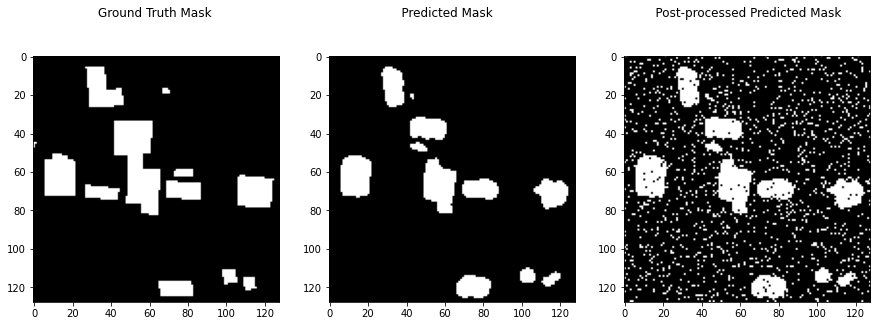

In [ ]:
# Select an example image to demonstrate the outcome of post-processing: 'Other' Group
# Img ID znz_3f8360_823_19_319456_270783 - Index 1200
# Img ID znz_06f252_254_19_319406_270726 - Index 1129
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig.suptitle('                Ground Truth Mask                                                 Predicted Mask                                          Post-processed Predicted Mask')
orig_array = np.reshape(split_test_orig_0[1129], (128,128))
orig_array = np.round(orig_array)
orig_array = np.rot90(orig_array, k=3)
orig_array = np.flip(orig_array, axis=1)
ax2.imshow(np.squeeze(orig_array),cmap='gray')
pred_array = np.reshape(split_test_0[1129], (128,128))
pred_array = np.round(pred_array)
pred_array = np.rot90(pred_array, k=3)
pred_array = np.flip(pred_array, axis=1)
ax3.imshow(np.squeeze(pred_array),cmap='gray')
mask_array = np.reshape(split_test_masks_0[1129], (128,128))
mask_array = np.rot90(mask_array, k=3)
mask_array = np.flip(mask_array, axis=1)
ax1.imshow(np.squeeze(mask_array),cmap='gray')
plt.show()

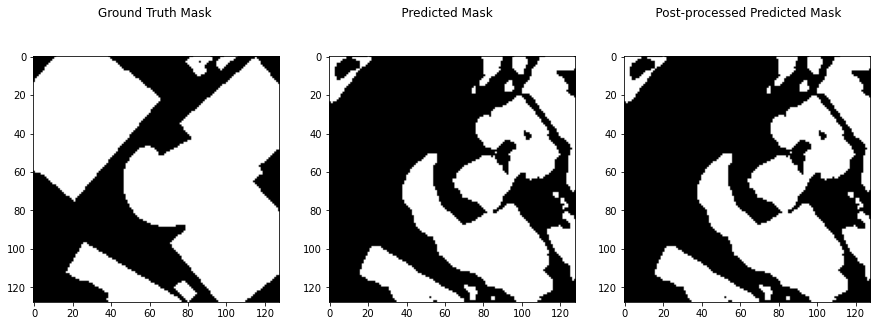

In [ ]:
#Img ID dar_0a4c40_363_19_319358_272084

fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig.suptitle('                Ground Truth Mask                                                 Predicted Mask                                          Post-processed Predicted Mask')
orig_array = np.reshape(split_test_orig_1[100], (128,128))
orig_array = np.round(orig_array)
orig_array = np.rot90(orig_array, k=3)
orig_array = np.flip(orig_array, axis=1)
ax2.imshow(np.squeeze(orig_array),cmap='gray')
pred_array = np.reshape(split_test_1[100], (128,128))
pred_array = np.round(pred_array)
pred_array = np.rot90(pred_array, k=3)
pred_array = np.flip(pred_array, axis=1)
ax3.imshow(np.squeeze(pred_array),cmap='gray')
mask_array = np.reshape(split_test_masks_1[100], (128,128))
mask_array = np.rot90(mask_array, k=3)
mask_array = np.flip(mask_array, axis=1)
ax1.imshow(np.squeeze(mask_array),cmap='gray')
plt.show()

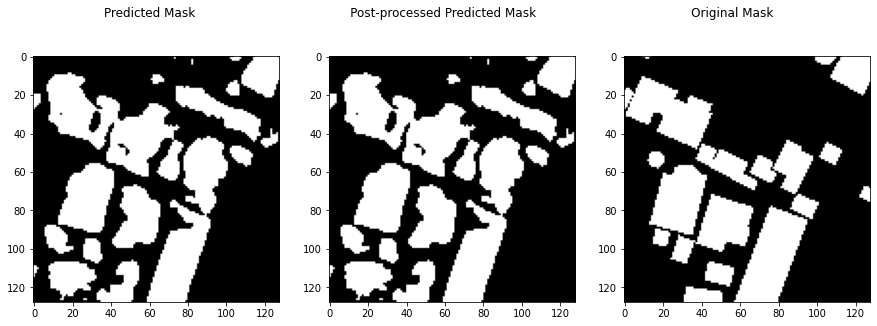

In [ ]:
#Img ID dar_0a4c40_1328_19_319376_272108

fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Predicted Mask                                        Post-processed Predicted Mask                                        Original Mask')
orig_array = np.reshape(split_test_orig_1[246], (128,128))
orig_array = np.round(orig_array)
orig_array = np.rot90(orig_array, k=3)
orig_array = np.flip(orig_array, axis=1)
ax1.imshow(np.squeeze(orig_array),cmap='gray')
pred_array = np.reshape(split_test_1[246], (128,128))
pred_array = np.round(pred_array)
pred_array = np.rot90(pred_array, k=3)
pred_array = np.flip(pred_array, axis=1)
ax2.imshow(np.squeeze(pred_array),cmap='gray')
mask_array = np.reshape(split_test_masks_1[246], (128,128))
mask_array = np.rot90(mask_array, k=3)
mask_array = np.flip(mask_array, axis=1)
ax3.imshow(np.squeeze(mask_array),cmap='gray')
plt.show()

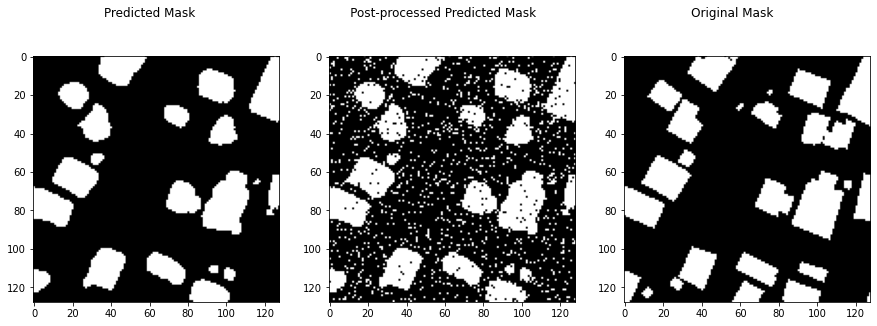

In [ ]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Predicted Mask                                        Post-processed Predicted Mask                                        Original Mask')
orig_array = np.reshape(split_val_orig_0[184], (128,128))
orig_array = np.round(orig_array)
orig_array = np.rot90(orig_array, k=3)
orig_array = np.flip(orig_array, axis=1)
ax1.imshow(np.squeeze(orig_array),cmap='gray')
pred_array = np.reshape(split_val_0[184], (128,128))
pred_array = np.round(pred_array)
pred_array = np.rot90(pred_array, k=3)
pred_array = np.flip(pred_array, axis=1)
ax2.imshow(np.squeeze(pred_array),cmap='gray')
mask_array = np.reshape(split_val_masks_0[184], (128,128))
mask_array = np.rot90(mask_array, k=3)
mask_array = np.flip(mask_array, axis=1)
ax3.imshow(np.squeeze(mask_array),cmap='gray')
plt.show()

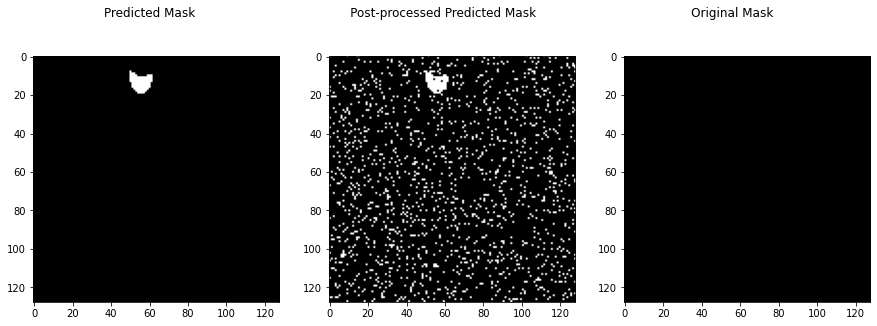

In [ ]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig.suptitle('Predicted Mask                                        Post-processed Predicted Mask                                        Original Mask')
orig_array = np.reshape(split_val_orig_0[150], (128,128))
orig_array = np.round(orig_array)
ax1.imshow(np.squeeze(orig_array),cmap='gray')
pred_array = np.reshape(split_val_0[150], (128,128))
pred_array = np.round(pred_array)
ax2.imshow(np.squeeze(pred_array),cmap='gray')
mask_array = np.reshape(split_val_masks_0[150], (128,128))
ax3.imshow(np.squeeze(mask_array),cmap='gray')
plt.show()